## Bi-Weekly 3
### Brian Cain
#### Tabular_2_Image.ipynb

This past week Dr. Raissi mentioned during one lecture that Convolutional Nueral Networks are so useful because they are extremely smart and can fit small datasets in a way that results in high accuracy and good generalization. However, once datasets become massive other strategies like transformers work better for datasets like ImageNet.

This motivated me to explore the possibility of transforming a small tabular dataset into an image dataset and seeing if the results are better in a convolutional neural network than they are in another standard ML Model. Below I have described the setup. 

<b>Set-up:</b> 
* This summer I did some data wrangling on historical college football game outcomes and made a predictive Random Forest model that predicts the winner of a game at an accuracy rate of 67%
* In this experiment, I will load the data and manipulate it such that it takes the form of image data rather than tabular data
* In addition to this, I will apply some concepts covered in the "Small Networks" module like pruning in order to see if the accuracy can even be further enhanced

In [1]:
##Import necessary packages
import pandas as pd
import numpy as np

##Pull in the data
##Import the aggregated dataset and display
gameRecords = pd.read_csv('D:\College_Football_Model_Data\\gameRecords_df.csv')
gameRecords.head(10)

,gameId,school,week_num,season,homeBool,talent_points_avg,talent_rank_avg,win,rush_td_movAvg,pass_td_movAvg,...,opp_points_Q4_movAvg,opp_talent_points_avg_movAvg,opp_talent_rank_avg_movAvg,diff_points_movAvg,diff_rush_yards_movAvg,diff_pass_yards_movAvg,diff_total_yards_movAvg,diff_turnovers_movAvg,games_played,games_won
0,400548194,Louisiana,4,2014,1,109.153333,90.333333,0.0,1.333333,2.000000,...,8.000000,134.774444,82.555556,-10.333333,30.000000,-69.000000,-39.000000,2.666667,3.0,1.0
1,400548267,Washington State,4,2014,1,165.193333,58.666667,0.0,0.333333,4.333333,...,9.000000,127.826667,82.444444,10.333333,-134.000000,297.000000,163.000000,1.000000,3.0,1.0
2,400548198,Oregon State,4,2014,1,186.023333,43.666667,1.0,1.500000,2.000000,...,11.500000,82.251667,114.264340,11.500000,54.500000,154.500000,209.000000,-2.000000,2.0,2.0
3,400548195,Fresno State,4,2014,1,99.893333,96.000000,1.0,1.333333,1.333333,...,9.333333,229.554444,24.111111,-35.666667,-166.000000,-96.666667,-262.666667,0.666667,3.0,0.0
4,400548266,California,4,2014,1,219.476667,28.666667,0.0,1.500000,4.000000,...,1.500000,118.448333,89.333333,24.000000,71.500000,98.000000,169.500000,-0.500000,2.0,2.0
5,400548197,New Mexico State,4,2014,1,80.880000,109.666667,0.0,1.000000,2.333333,...,9.333333,74.917778,127.611111,2.000000,-94.666667,102.666667,8.000000,-0.333333,3.0,2.0
6,400560174,Houston,4,2014,1,160.453333,62.000000,1.0,1.333333,1.333333,...,3.333333,93.412222,104.000000,6.333333,-90.000000,85.000000,-5.000000,-0.666667,3.0,1.0
7,400547789,Nebraska,4,2014,1,226.696667,23.333333,1.0,3.000000,2.666667,...,2.333333,95.338889,104.801418,33.666667,195.000000,104.666667,299.666667,0.333333,3.0,3.0
8,400547742,Clemson,4,2014,1,253.693333,15.000000,0.0,3.000000,2.500000,...,10.500000,174.620000,67.166667,24.500000,10.500000,251.000000,261.500000,0.000000,2.0,1.0
9,400548414,Georgia Southern,4,2014,1,33.045000,133.000000,1.0,5.000000,1.333333,...,7.000000,138.945556,79.555556,23.666667,161.666667,-43.333333,118.333333,-0.666667,3.0,1.0


In the output above it can be seen that there is a table with unique Game Id's for every game player from the 2013-2019 season. Each game ID appears twice in the dataset, appearing the first time for the home teams data and a second time for the away teams data. Together, gameID and school make a primary key. Additionally in this dataset are a variety of aggregated average stats for each team that season, including how much recruiting talent they have, their average offensive yards, winning percentage, and more. 

Note: 2020 was omitted during my summer work because it was a weird year with statistics in football as a result of covid.

This dataset is great, but it must condense each game into a single observation, which leads us to viewing another dataset that I created this summer which I will pull in now, but the above dataset gives a general idea of where the next dataset comes from. 

In [2]:
##Clear old data from memory
del gameRecords

##Pull in new data
data = pd.read_csv('D:\College_Football_Model_Data\Final_Pretrain_Data.csv',index_col=False)

##Display the data
data.head()

,Unnamed: 0,gameId,school,week_num,season,homeBool,win,games_played,games_won,quickStart,...,net_diff_turnovers_movAvg,net_winPct,net_off_field_pos_eff,off_rush_advantage,off_pass_advantage,def_rush_advantage,def_pass_advantage,scoring_advantage,win_margin_advantage,turnover_margin_advantage
0,707,400787446,Liberty,5,2015,1,1.0,1.0,0.0,1,...,0.516971,0.333333,4.748207,0,0,1,0,0,0,1
1,3080,401112126,Texas Tech,6,2019,0,1.0,4.0,2.0,0,...,0.583551,0.350000,3.239068,0,0,0,1,0,0,1
2,178,400548367,Kentucky,7,2014,1,1.0,5.0,4.0,0,...,0.548303,0.600000,-4.827132,1,1,0,1,1,1,1
3,2918,401012797,Oregon,13,2018,0,1.0,10.0,7.0,0,...,0.529077,0.759091,-3.017582,1,1,1,1,1,1,1
4,2527,401015009,UAB,6,2018,0,1.0,4.0,3.0,0,...,0.595300,0.500000,-0.604865,1,0,0,1,1,1,0


With a quick glance, it can be observed that in previous steps I have already normalized the dataset using min-max normalization, and as well some "advantage" categorical features were added to each observation to try and grant a model more insight into which teams have certain offensive/defensive advantages. 

Let's explore what columns we have in the dataset:

In [3]:
##Display columns that are present within the dataset
print('Columns in College Football Dataset:')
print('------------------------------------')
for i in data.columns:
    print(i)

Columns in College Football Dataset:
------------------------------------
Unnamed: 0
gameId
school
week_num
season
homeBool
win
games_played
games_won
quickStart
opposition_homeBool
opposition_win
opposition_games_played
opposition_games_won
net_talent_points_avg
net_talent_rank_avg
net_rush_td_movAvg
net_pass_td_movAvg
net_rush_attempt_movAvg
net_yp_rush_movAvg
net_rush_yards_movAvg
net_yp_pass_movAvg
net_pass_yards_movAvg
net_total_yards_movAvg
net_turnovers_movAvg
net_completion_pct_movAvg
net_points_movAvg
net_points_Q1_movAvg
net_points_Q2_movAvg
net_points_Q3_movAvg
net_points_Q4_movAvg
net_opp_rush_td_movAvg
net_opp_pass_td_movAvg
net_opp_yp_rush_movAvg
net_opp_rush_yards_movAvg
net_opp_yp_pass_movAvg
net_opp_pass_yards_movAvg
net_opp_total_yards_movAvg
net_opp_turnovers_movAvg
net_opp_completion_pct_movAvg
net_opp_points_movAvg
net_opp_points_Q1_movAvg
net_opp_points_Q2_movAvg
net_opp_points_Q3_movAvg
net_opp_points_Q4_movAvg
net_opp_talent_points_avg_movAvg
net_opp_talent_rank

In the columns listed above, you can notice there are a lot of columns that start with "net", these columns indicated the normalized net difference in the home and away teams average statistics for the season for each metric. 

We can also notice, that from a predictive standpoint, there are columns we don't need to include when changing each tabular observation into an image, these columns are gameId, school, week_num, season, and perhaps a few other "garbage" statistics that we might want to leave out. Also note that the win column are the labels, with 0 being a loss, and 1 being a win. 

In [4]:
##Create a list of columns that we would like to keep for prediction
cols_to_keep = ['quickStart','net_talent_points_avg','net_talent_rank_avg','net_rush_td_movAvg',
                'net_pass_td_movAvg','net_rush_attempt_movAvg','net_yp_rush_movAvg','net_rush_yards_movAvg',
                'net_yp_pass_movAvg','net_pass_yards_movAvg','net_total_yards_movAvg','net_turnovers_movAvg',
                'net_completion_pct_movAvg','net_points_movAvg','net_opp_rush_td_movAvg','net_opp_pass_td_movAvg',
                'net_opp_yp_rush_movAvg','net_opp_rush_yards_movAvg','net_opp_yp_pass_movAvg',
                'net_opp_pass_yards_movAvg','net_opp_total_yards_movAvg','net_opp_turnovers_movAvg',
                'net_opp_completion_pct_movAvg','net_opp_points_movAvg','net_opp_points_Q1_movAvg',
                'net_opp_points_Q2_movAvg','net_opp_points_Q3_movAvg','net_opp_points_Q4_movAvg',
                'net_diff_points_movAvg','net_diff_rush_yards_movAvg','net_diff_pass_yards_movAvg',
                'net_diff_total_yards_movAvg','net_diff_turnovers_movAvg','net_winPct','net_off_field_pos_eff',
                'off_rush_advantage','off_pass_advantage','def_rush_advantage','def_pass_advantage',
                'scoring_advantage','win_margin_advantage','turnover_margin_advantage']

##Filter the dataset
labelsData = data['win']
data = data[cols_to_keep]

Below I define a function to turn the data into image arrays and image labels:

In [5]:
##Now turn the dataframe into a list of lists
data = data.values.tolist()
labels = np.array(labelsData.values.tolist())

Create 8x6 images

In [6]:
ct = 0
for i in data:
    data[ct] = np.reshape(i, (7,6))
    ct+=1

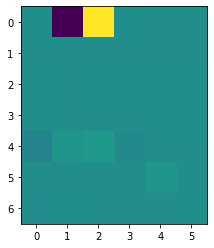

In [7]:
import matplotlib.pyplot as plt
plt.imshow(data[0])

In [8]:
x_train = data[:2681]
y_train = labels[:2681]
x_test = data[2681:]
y_test = labels[2681:]

In [9]:
np.array(x_train).shape

(2681, 7, 6)

In [10]:
##Create a validation set
##Split training data so we have a validation set
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

In [12]:
import tensorflow as tf

##Create model
model2 = tf.keras.models.Sequential()

##Add a layer with 32 filters for a 1x1 convolution
model2.add(tf.keras.layers.Conv2D(32, (1, 1), activation='relu', input_shape=(7,6,1))) ##Grayscale input shape
model2.add(tf.keras.layers.MaxPooling2D((3, 3),padding='valid')) ##Perform a 3x3 max-pooling
##Add a layer that generates 64 feature maps and max pools again with 3x3 
model2.add(tf.keras.layers.Conv2D(64, (1, 1), activation='relu'))

##Perform final convolution operations and conduct global average pooling with 128 feature maps
model2.add(tf.keras.layers.Conv2D(128, (1, 1), activation='relu'))
model2.add(tf.keras.layers.GlobalAveragePooling2D())

##Add a single dense layer after global average pooling
model2.add(tf.keras.layers.Dense(1, activation='softmax')) ##Must have 9 neurons

##Check out the model architecture
model2.summary()

##Compile the model
model2.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

##Fit our created model over 10 epochs (Batch size of 6,000)
model2_fit = model2.fit(x_train, y_train, batch_size=24, epochs=200, validation_data=(x_val, y_val),verbose=2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 7, 6, 32)          64        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 2, 64)          2112      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 2, 2, 128)         8320      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 10,625
Trainable params: 10,625
Non-trainable params: 0
__________________________________________________

KeyboardInterrupt: 

### Next Steps

(mention something about making a more customized loss function)